In [8]:
import matplotlib.pyplot as plt

# 日本語が表示できるフォントに変更（Windows想定）
plt.rcParams["font.family"] = "MS Gothic"   # または "Yu Gothic", "Meiryo" など
plt.rcParams["axes.unicode_minus"] = False  # マイナス記号が□になるのを防ぐ


# Face Detection Notebook

## テーマ（Use Case）
街や製品には“顔っぽいデザイン”がどれだけ存在するのかを、顔検出で可視化・カウントする。

## 1. 画像の読み込み

本課題では、次の3種類の画像を用いる。

- 実際の人の顔写真：`real_human_01.jpg`
- 現実の「顔っぽい」モノ：`real_object_01.jpg`, `real_object_02.jpg`
- AI が生成した顔・顔っぽい画像：  
  `ai_human_01.png`, `ai_human_02.png`,  
  `ai_object_01.png`, `ai_object_02.png`, `ai_object_03.png`, `ai_object_04.png`


## ケース1：実写の顔写真での顔検出

ここでは、顔検出の基本的な動作を確認するために、
自分の顔写真 `real_human_01.jpg` を使って顔検出を行う。

- 画像の内容：自分自身の顔が写っている写真。
- 条件：室内で撮影した、比較的明るい環境の1枚。顔の向きや表情は自然な状態のスナップ写真。
- ねらい：
  - 「普通の顔写真」の場合、顔検出モデルがどのように反応するかを確認する。
  - 後で扱う「AIの顔」や「顔っぽいモノ」と比較するための基準となるケース。


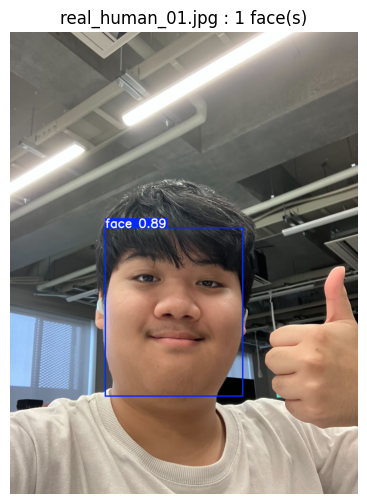

検出された顔の数: 1


In [5]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# 1. 画像とモデルのパス
image_path = Path("images/real_human_01.jpg")   # 実際の人の顔写真
model_path = Path("yolov8m-face.pt")           # 参考ノートと同じ YOLO 顔モデル

if not image_path.exists():
    raise FileNotFoundError(f"画像ファイルが見つかりません: {image_path}")

if not model_path.exists():
    raise FileNotFoundError(f"モデルファイルが見つかりません: {model_path}")

# 2. YOLO モデルの読み込み
model = YOLO(model_path)

# 3. 画像に対して顔検出を実行
#    conf は信頼度しきい値、imgsz は推論時の解像度
result = model.predict(
    source=str(image_path),
    conf=0.25,
    verbose=False,
    imgsz=640  # 参考ノートより少し軽めでもOK。重くしたければ 1280 とかでもよい
)[0]

# 4. YOLO の結果を可視化用の画像として取得
#    result.plot() は、検出結果を描画した BGR 配列を返してくれる（参考ノートの簡易版）
annotated_bgr = result.plot()

# 5. BGR → RGB に変換して表示
annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.title(f"real_human_01.jpg : {len(result.boxes)} face(s)")
plt.show()

print(f"検出された顔の数: {len(result.boxes)}")


### ケース1の結果と考察（実写の顔写真）

- 自分の顔写真 `real_human_01.jpg` に対して、顔検出モデルは顔の位置を正しく検出できた。
- 顔のまわりに描画されたバウンディングボックスは、おおよそ「顔全体」をカバーしており、
  目・鼻・口のあたりを含む範囲を囲んでいた。

**ここから分かること**

- 明るさや解像度が十分で、顔が画面の中である程度の大きさを占めている場合、
  今回のモデルは「ふつうの顔写真」に対して安定して反応できると考えられる。
- このケースは、後のケース（AIの顔や顔っぽいモノ）の比較用の「基準」として使える。
  つまり、「実際の人間の顔なら問題なく検出できる状態からスタートしている」と言える。


## ケース2：現実の「顔に見えるモノ」での顔検出

ここでは、人間の顔ではないが、形や配置のせいで「顔」に見えるモノを撮影した
2枚の画像を使って顔検出を行う。

- `real_object_01.jpg`  
  現実の物体の一部が、目や口のように見える構図の写真。  
  人間の顔そのものではないが、パーツの配置が顔に近く見える。

- `real_object_02.jpg`  
  別の種類の「顔っぽく見える」物体を撮影した写真。  
  こちらも人ではないが、見る人によっては顔を連想しやすい配置になっている。

ねらい：
- 顔ではない「顔っぽいモノ」に対して、YOLO が顔として反応するか（誤検出が起きるか）を確認する。
- ケース1の「実写の顔」との違いを、あとで分析しやすくするための材料にする。


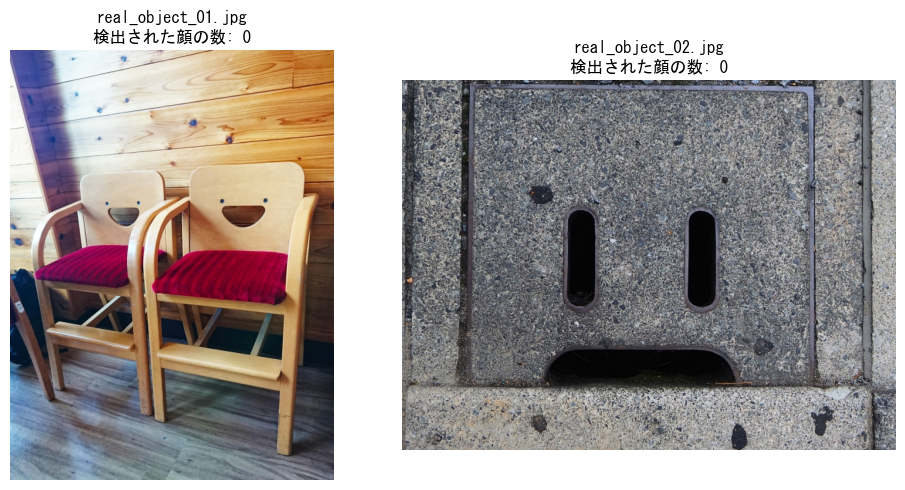

In [9]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# 顔用YOLOモデルのパス（.ipynbと同じ階層に置いてある想定）
model_path = Path("yolov8m-face.pt")

if not model_path.exists():
    raise FileNotFoundError(f"モデルファイルが見つかりません: {model_path}")

model = YOLO(model_path)

# ケース2で使う2枚の画像パス
image_paths = [
    Path("images/real_object_01.jpg"),
    Path("images/real_object_02.jpg"),   # 実際のファイル名が .jpg.jpg ならここを合わせてね
    # Path("images/real_object_02.jpg.jpg"),
]

# 実際に存在するものだけ使う
valid_paths = []
for p in image_paths:
    if p.exists():
        valid_paths.append(p)
    else:
        print(f"画像ファイルが見つかりません: {p}")

if not valid_paths:
    print("表示できる画像がありません。")
else:
    plt.figure(figsize=(10, 5))

    for idx, img_path in enumerate(valid_paths, start=1):
        # 1枚ずつ顔検出
        result = model.predict(
            source=str(img_path),
            conf=0.25,
            imgsz=640,
            verbose=False
        )[0]

        # 枠付き画像を取得してRGBに変換
        annotated_bgr = result.plot()
        annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

        # 横に並べて表示
        plt.subplot(1, len(valid_paths), idx)
        plt.imshow(annotated_rgb)
        plt.axis("off")
        plt.title(f"{img_path.name}\n検出された顔の数: {len(result.boxes)}")

    plt.tight_layout()
    plt.show()


### ケース2の結果と考察（現実の「顔に見えるモノ」）

- `real_object_01.jpg` と `real_object_02.jpg` では、
  どちらの画像でも **検出された顔の数は 0** だった。
- 人間が見ると「目と口があるように見える」「顔っぽい配置だ」と感じるが、
  顔検出モデルはこれらを「顔」とは判定しなかった。

**ここから分かること**

- 今回のモデルは、「人間の脳が顔と感じるパターン」よりも、
  より厳密な顔の特徴（肌の質感や目・鼻・口の細かい形など）を見て判定している可能性がある。
- 人間は、車のライトや窓の配置なども「顔」に見えてしまうことがあるが、
  モデルはそのような“なんとなく顔っぽい”パターンには反応しなかった。
- これは、**監視カメラや出席管理のような用途では、余計なモノを誤検出しにくい**という意味で
  「メリット」として考えることもできる。
- 一方で、「街の中にどれくらい顔っぽいデザインがあるか」を数える今回のようなテーマでは、
  人間の感覚とモデルの判定が一致しないため、
  「顔っぽさ」の分析には向いていない面も見えてきた。


## ケース3：AI が生成した「人間の顔」での顔検出

ここでは、画像生成 AI が作った「人の顔」に見える画像  
`ai_human_01.png`, `ai_human_02.png` を使って顔検出を行う。

- 画像の内容：実在の人物ではなく、画像生成 AI によって作られた「人間の顔」の画像。
- 特徴：
  - 一見すると普通の人物写真のように見えるが、すべて人工的に作られた顔である。
  - 目・鼻・口の位置関係や輪郭は人間の顔に近いが、細部に不自然さや独特な質感が含まれている可能性がある。
- ねらい：
  - ケース1の「実際の人間の顔」と比べて、AI が作った顔にも同じように反応するかを確かめる。
  - 実写の顔と、AI 生成の顔のあいだで、検出のしやすさに差があるかどうかを後で考察するための材料にする。


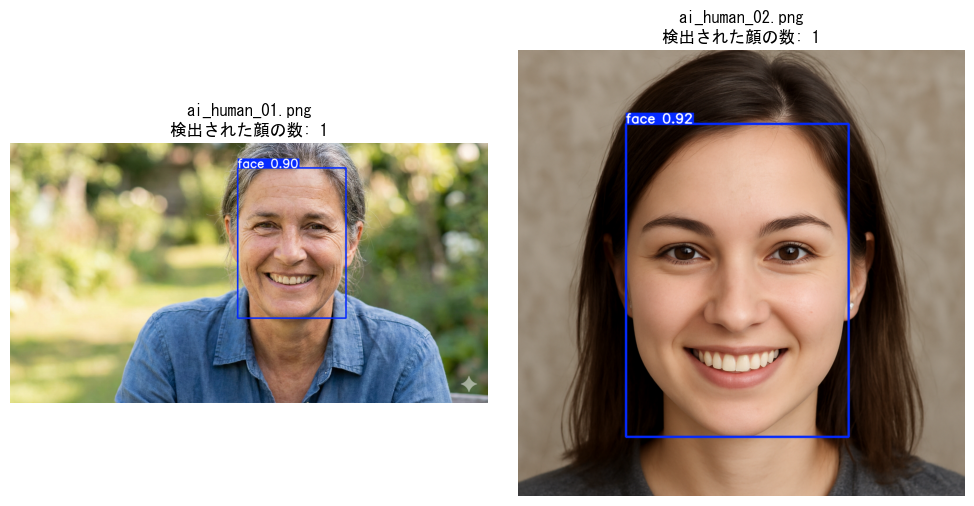

In [10]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# 顔用YOLOモデル
model_path = Path("yolov8m-face.pt")
if not model_path.exists():
    raise FileNotFoundError(f"モデルファイルが見つかりません: {model_path}")

model = YOLO(model_path)

# ケース3で使うAI顔画像
image_paths = [
    Path("images/ai_human_01.png"),
    Path("images/ai_human_02.png"),
]

# 実際に存在するものだけ使う
valid_paths = []
for p in image_paths:
    if p.exists():
        valid_paths.append(p)
    else:
        print(f"画像ファイルが見つかりません: {p}")

if not valid_paths:
    print("表示できる画像がありません。")
else:
    plt.figure(figsize=(10, 5))

    for idx, img_path in enumerate(valid_paths, start=1):
        # 1枚ずつ顔検出
        result = model.predict(
            source=str(img_path),
            conf=0.25,
            imgsz=640,
            verbose=False
        )[0]

        # 枠付き画像を取得してRGBに変換
        annotated_bgr = result.plot()
        annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

        # 横に並べて表示
        plt.subplot(1, len(valid_paths), idx)
        plt.imshow(annotated_rgb)
        plt.axis("off")
        plt.title(f"{img_path.name}\n検出された顔の数: {len(result.boxes)}")

    plt.tight_layout()
    plt.show()


### ケース3の結果と考察（AI が生成した人間の顔）

- `ai_human_01.png` と `ai_human_02.png` のどちらの画像でも、顔検出モデルは顔を「普通に」検出できた。
- 枠の位置も、実写の顔写真（ケース1）と同じように、顔全体をおおよそ正しく囲んでいた。
- 少なくとも、主要な顔については見逃しがなく、実写の顔と同じような反応を示しているように見えた。

**ここから分かること**

- モデルは「本物の人間かどうか」ではなく、**顔としてのパターン（目・鼻・口の位置や輪郭）**を見て判定していると考えられる。
- 実在の人物ではない AI 生成の顔であっても、実写の顔写真（ケース1）とほぼ同じように検出できているため、
  **「人間の顔っぽく作られた画像」に対しても感度が高い**ことが分かる。
- 一方で、こうした結果は、プロフィール画像やアイコンなどが AI で作られていても、
  顔検出の精度があまり落ちないことを意味する一方で、
  「実在の人物かどうか」を区別することは今回のモデルだけではできないことも示している。
- 今回のテーマ（街や製品の“顔っぽさ”を調べる）という観点では、
  **「AI が作った顔」と「本物の顔」のあいだに、モデル側はほとんど差をつけていない**という点が興味深い。


## ケース4：AI が生成した「人に見えるモノ」での顔検出

ここでは、画像生成 AI に「人に見えるモノ」や「人型のシルエット」を作らせた画像  
`ai_object_01.png`, `ai_object_02.png`, `ai_object_03.png`, `ai_object_04.png` を使って顔検出を行う。

- 画像の内容：
  - 完全な人間の顔ではなく、物体や抽象的な形が「人の顔」や「人型」に見えるように作られた画像。
- 特徴：
  - 目や口のように見えるパーツが含まれているものもあれば、かなり抽象的なものもある。
  - 人間の目には「なんとなく人っぽく見える」が、厳密な意味での“顔”とは言えないパターンも多い。
- ねらい：
  - ケース2（現実の顔っぽいモノ）との違いを、AI 生成の例で確認する。
  - モデルが「人間の顔」からどこまで離れたパターンまで顔として反応するのか、境界を探る材料にする。


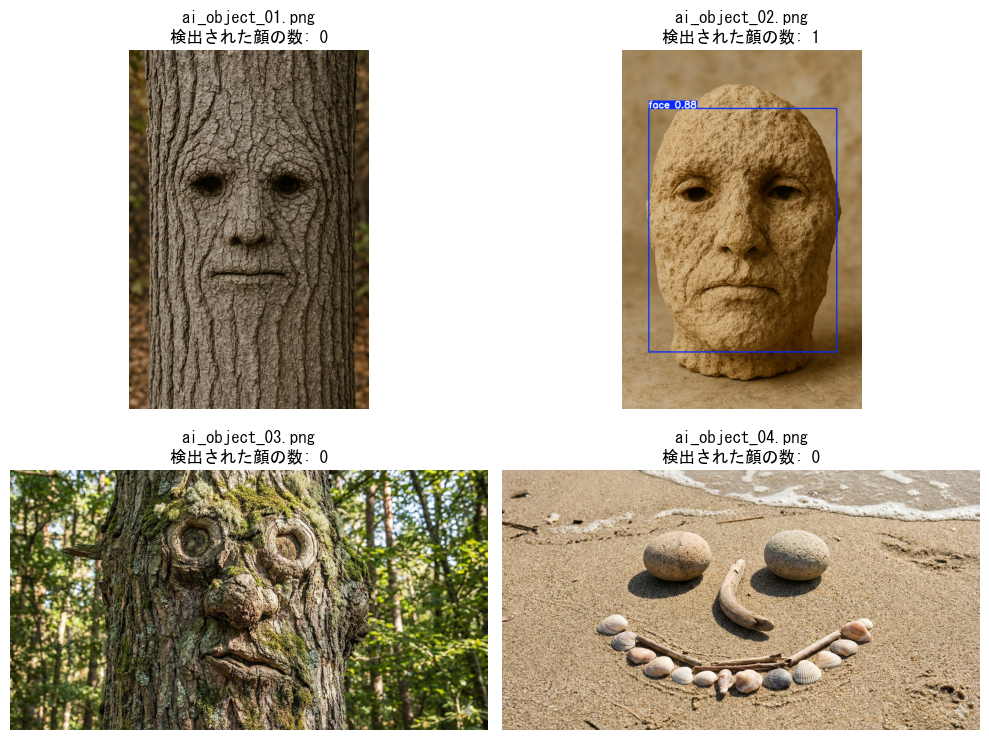

In [11]:
from ultralytics import YOLO
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# 顔用YOLOモデル
model_path = Path("yolov8m-face.pt")
if not model_path.exists():
    raise FileNotFoundError(f"モデルファイルが見つかりません: {model_path}")

model = YOLO(model_path)

# ケース4で使う AI 生成の「人に見えるモノ」の画像
image_paths = [
    Path("images/ai_object_01.png"),
    Path("images/ai_object_02.png"),
    Path("images/ai_object_03.png"),
    Path("images/ai_object_04.png"),
]

# 実際に存在するファイルだけ使う
valid_paths = []
for p in image_paths:
    if p.exists():
        valid_paths.append(p)
    else:
        print(f"画像ファイルが見つかりません: {p}")

if not valid_paths:
    print("表示できる画像がありません。")
else:
    # 2×2 みたいなグリッドで見やすく並べる
    n = len(valid_paths)
    cols = 2
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(10, 8))

    for idx, img_path in enumerate(valid_paths, start=1):
        # 1枚ずつ顔検出
        result = model.predict(
            source=str(img_path),
            conf=0.25,
            imgsz=640,
            verbose=False
        )[0]

        # 枠付き画像を取得してRGBに変換
        annotated_bgr = result.plot()
        annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

        # グリッド表示
        plt.subplot(rows, cols, idx)
        plt.imshow(annotated_rgb)
        plt.axis("off")
        plt.title(f"{img_path.name}\n検出された顔の数: {len(result.boxes)}")

    plt.tight_layout()
    plt.show()


### ケース4の結果と考察（AI が生成した「人に見えるモノ」）

#### 検出結果の整理

- `ai_object_01.png`：検出された顔の数 0  
  → 木の幹の模様が顔のように見える画像だが、モデルは顔として認識しなかった。

- `ai_object_02.png`：検出された顔の数 1  
  → 石や粘土で作られたような「頭部の彫刻」が写っており、モデルはこれを顔として検出した。

- `ai_object_03.png`：検出された顔の数 0  
  → 木の幹に目・鼻・口のような形がついているが、こちらも顔としては検出されなかった。

- `ai_object_04.png`：検出された顔の数 0  
  → 砂浜に石や貝殻を並べて作ったスマイルマークのような配置だが、顔としては検出されなかった。

#### 元画像から読み取れる特徴

- 人間の目で見ると、4枚とも「それなりに顔っぽく」感じられる。
  - 01・03：木の幹に顔が浮かび上がっているように見える。
  - 04：目と口だけを記号的に並べたシンプルな“顔マーク”になっている。
  - 02：頭の形や目・鼻・口がはっきりした、ほぼ「石像の顔」と言えるデザインになっている。

しかし、モデルが「顔」と判定したのは `ai_object_02.png` だけだった。

#### 考察：モデルが重視しているポイント

この結果から、今回の顔検出モデルは次のような特徴を持っていると考えられる。

- 単に「目と口らしきものが並んでいるか」だけでなく、
  - 頭部の輪郭があるか  
  - 顔全体のバランスが人間に近いか  
  - 肌や立体的な顔に近い質感か  
  といった情報をまとめて見ている可能性が高い。
- そのため、
  - 木の幹や砂浜のように、背景の素材感が強く出ている「顔っぽい模様」は、
    人間には顔に見えても、モデルにとっては「ただの模様」として扱われやすい。
  - 一方で、`ai_object_02.png` のように「頭の形をした彫刻の顔」は、
    実写の顔やマネキンに近い対象として検出されたと考えられる。

#### まとめ

- AI が作った「人に見えるモノ」を使ったケース4では、  
  **“かなり人間の顔に近いデザイン”だけが顔として認識され、  
  より抽象的な「顔っぽい模様」にはほとんど反応しない** という結果になった。
- これは、「人間の脳が感じる顔っぽさ」と、  
  顔検出モデルの「顔」の定義のあいだにギャップがあることを示している。


## 総括：今回の実験から分かったこと

### 1. 人間の顔に対する YOLO の挙動

- ケース1（自分の顔の写真）では、顔検出モデルは顔の位置を安定して検出できた。
- ケース3（AI が生成した人間の顔）でも、実写と同じように顔を検出できていた。
- このことから、今回使った YOLO ベースの顔検出モデルは、
  **「実在する人かどうか」ではなく、「人間の顔の形やパターン」に反応している**
  ことが分かった。

→ 実写でも AI 生成でも、「人間の顔としてしっかり作られている画像」であれば、
   顔検出という目的には十分使えると考えられる。

---

### 2. 「顔に見えるモノ」に対する挙動

- ケース2（現実の「顔に見えるモノ」）では、
  どちらの画像でも検出された顔の数は **0** だった。
- ケース4（AI が生成した「人に見えるモノ」）では、
  4枚のうち **1枚だけ（石像のような顔）** が顔として検出され、
  木の幹の顔や、貝殻で作ったスマイルマークなどはすべて検出されなかった。
- 人間の目にはどれも「それなりに顔っぽく」見えるが、
  モデルは以下のような条件がそろっていないと、顔として扱わないように見える。
  - 頭の輪郭がはっきりしている
  - 目・鼻・口の位置関係が人間の顔にかなり近い
  - 素材や質感が「肌」や「立体的な顔」に近い

→ **人間の“なんとなく顔に見える”感覚（パレイドリア）と、
   モデルの「顔」判定は大きく違う** という結果になった。

---

### 3. 今回のテーマとの関係
**テーマ：  
「街や製品には“顔っぽいデザイン”がどれだけ存在するのかを、顔検出で可視化・カウントする。」**

- 人間の感覚では、木の幹・窓・貝殻の並びなど、街の中にたくさんの「顔っぽい」ものを見つけることができる。
- しかし、今回の顔検出モデルが反応したのは、
  - 自分の顔（ケース1）
  - AI 生成の人間の顔（ケース3）
  - AI 生成の石像に近い顔（ケース4の一部）
  のような、「かなり人間の顔に近いもの」にほぼ限られていた。
- そのため、このモデルをそのまま使って
  「街や製品に含まれる“顔っぽいデザインの数”をカウントする」と、
  実際の人間の感覚よりも、かなり少ない数しか検出できないと考えられる。

→ 結論として、  
  **今回の顔検出モデルは、“人間としての顔”には強いが、  
  “人がなんとなく顔だと思うデザイン”を数える用途にはあまり向いていない**  
  という限界が見えてきた。

---

### 4. YOLO（今回の顔検出モデル）の強みと弱み（今回の実験ベース）

**強み**

- 実写の顔写真だけでなく、AI が生成した人物の顔も安定して検出できた。
- 木や貝殻など、「顔ではないもの」に対しては基本的に反応しないため、
  監視カメラや出席確認など、「人の顔だけを検出したい」場面では
  **余計な誤検出が少ない**という点はメリットになる。

**弱み・限界**

- 人間が「顔っぽい」と感じるパターン（木の顔や砂浜のスマイルマークなど）は、
  ほとんど検出されなかった。
- 「顔」というラベルの中でも、
  - 実在の人の顔
  - AI が作った人物の顔
  - 顔の彫刻・仮面
  などには反応する一方、
  より抽象的な「顔に見える模様」には弱い。

---

### 5. 所感

- 実験前は、「人間の目には顔に見えるものなら、顔検出モデルもある程度反応するのではないか」と考えていた。
- しかし実際には、モデルは人間よりもかなり厳しい基準で「顔かどうか」を判断しており、
  **“顔っぽさ”の感覚をそのまま代用することはできない**ことが分かった。
- 一方で、AI 生成の人物の顔に対しては実写と同じように検出できていたため、
  これからの社会では、「AI が作った顔を含めて、人の顔らしい画像全体をどう扱うか」を
  考える必要があると感じた。
- 今回のテーマに対しては、
  単に顔検出モデルに任せるだけでなく、
  「どの程度“人間の顔に近いデザイン”を対象にするのか」を
  人間側で決めてあげる必要があると分かった。
